<a href="https://colab.research.google.com/github/G0rav/Image_Segmentation/blob/main/UNet_using_keras_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/images/segmentation

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://nbviewer.jupyter.org/github/G0rav/Image_Segmentation/blob/main/Unet.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'

In [4]:
pet, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteW9ZZ5U/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteW9ZZ5U/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [8]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.1837964>

In [10]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
train = pet['train'].map(load_image)
test = pet['test'].map(load_image)

In [12]:
len(train), len(test)

(3680, 3669)

In [13]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [14]:
def show_images(display_list,title_list):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title_list[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
  plt.show()

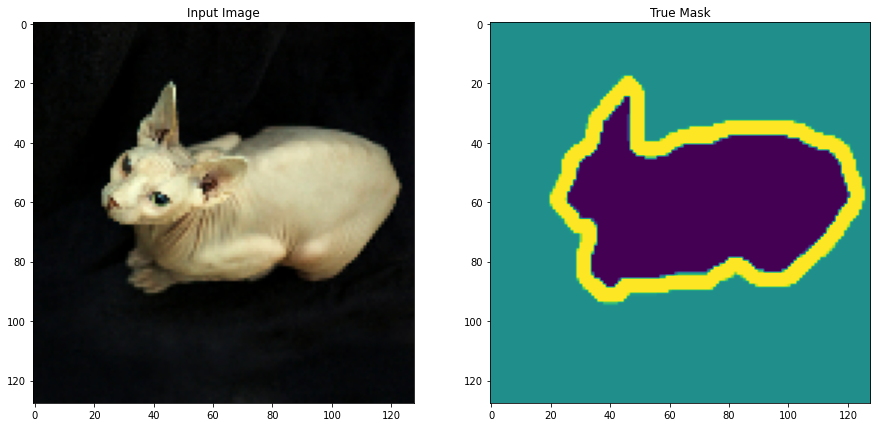

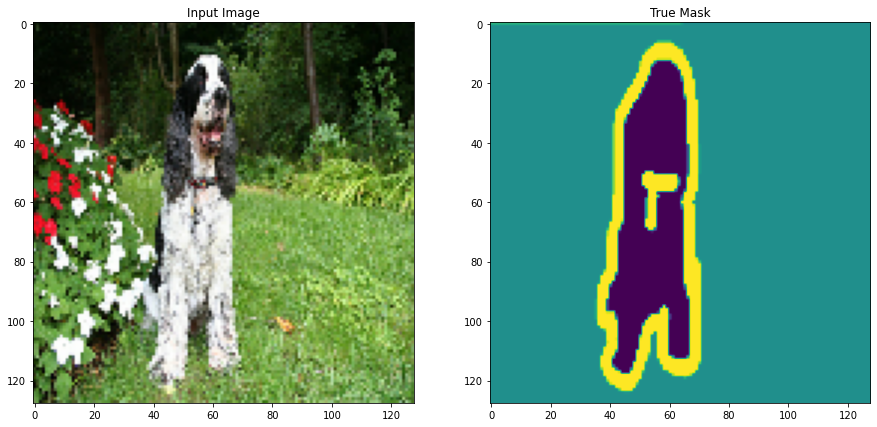

In [20]:
for image, mask in train.take(2):
  sample_image, sample_mask = image, mask
  show_images([sample_image, sample_mask],
        ['Input Image', 'True Mask'])



In [23]:
from tensorflow.keras import layers
import keras


def get_model():
    inputs = layers.Input(shape=[128,128,3])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

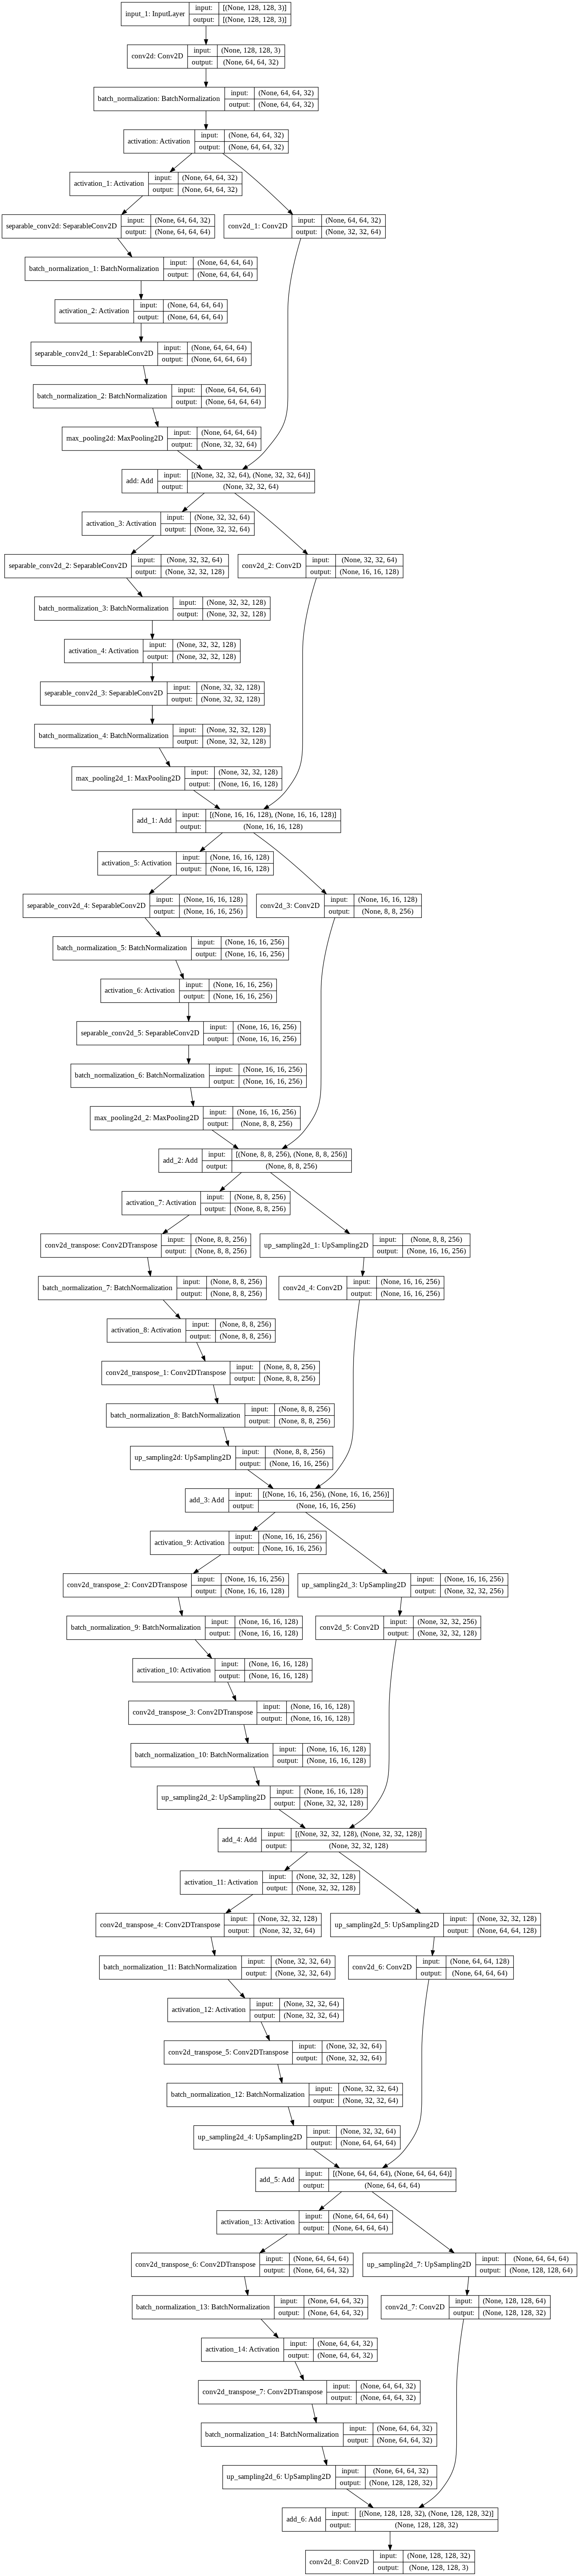

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Image segmentation/oxford_segmentation_keras_version.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/15
58/58 [==============================] - 35s 405ms/step - loss: 2.2057 - val_loss: 3.4376
Epoch 2/15
58/58 [==============================] - 22s 380ms/step - loss: 0.6196 - val_loss: 3.2437
Epoch 3/15
58/58 [==============================] - 22s 382ms/step - loss: 0.5656 - val_loss: 4.2592
Epoch 4/15
58/58 [==============================] - 22s 384ms/step - loss: 0.5233 - val_loss: 4.9146
Epoch 5/15
58/58 [==============================] - 22s 387ms/step - loss: 0.4959 - val_loss: 5.2124
Epoch 6/15
58/58 [==============================] - 22s 386ms/step - loss: 0.4662 - val_loss: 4.3109
Epoch 7/15
58/58 [==============================] - 22s 386ms/step - loss: 0.4339 - val_loss: 3.7856
Epoch 8/15
58/58 [==============================] - 22s 389ms/step - loss: 0.4153 - val_loss: 5.1101
Epoch 9/15
58/58 [==============================] - 23s 391ms/step - loss: 0.3849 - val_loss: 3.8088
Epoch 10/15
58/58 [==============================] - 22s 386ms/step - loss: 0.3648 - val_lo

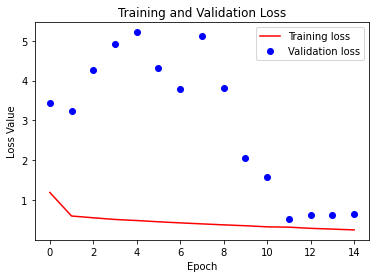

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

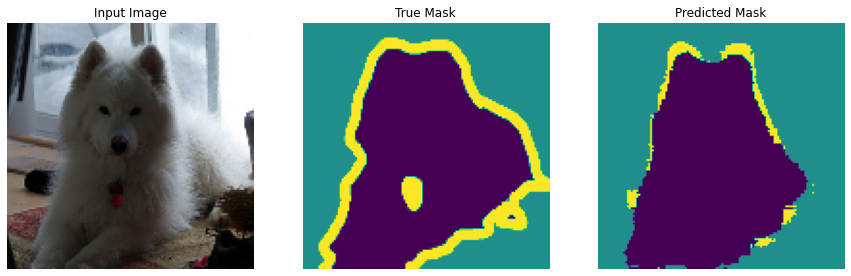

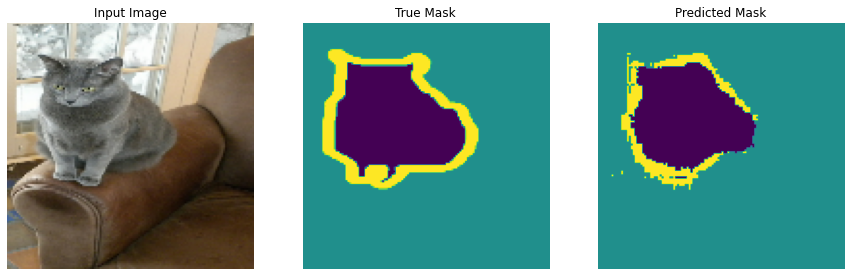

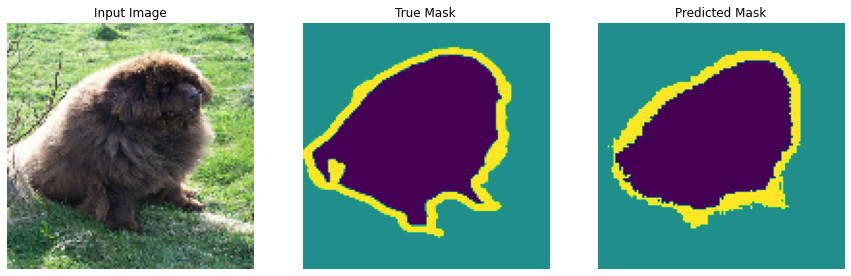

In [31]:
show_predictions(test_dataset, 3)

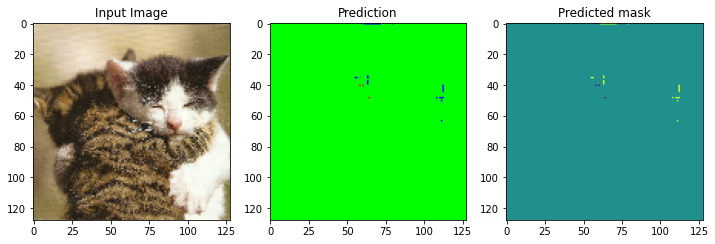

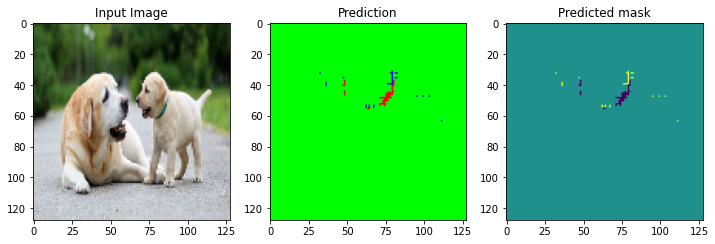

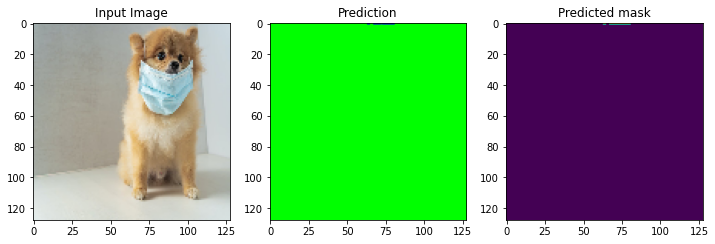

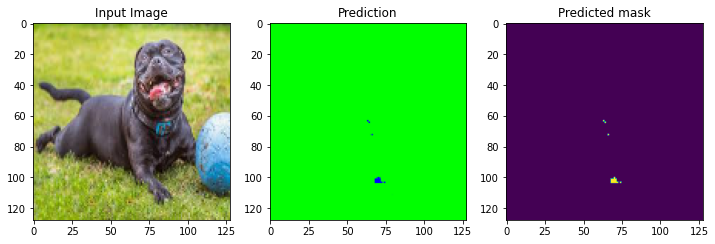

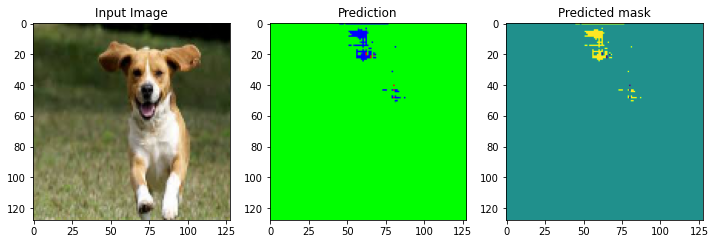

In [34]:
path ='/content/drive/MyDrive/Colab Notebooks/Image segmentation/'
for i in range(1,6):
  plt.figure(figsize= (12,12))
  
  plt.subplot(1,3,1)
  img = plt.imread(path + str(i)+'.jpg')
  img = cv2.resize(img, (128,128))
  plt.imshow(img)
  plt.title('Input Image')

  plt.subplot(1,3,2)
  img = img.reshape((1,) + img.shape)
  pred = model.predict(img)
  pred = pred.reshape(pred.shape[1:])
  plt.imshow(pred)
  plt.title('Prediction')

  plt.subplot(1,3,3)
  pred_mask = tf.argmax(pred, axis=-1)
  plt.imshow(pred_mask)
  plt.title('Predicted mask')
  plt.show()

#lvis

In [25]:
lvis, info = tfds.load('lvis', with_info=True)

DatasetNotFoundError: ignored